In [10]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder
from joblib import load

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import L1L2

In [23]:
df = pd.read_csv("train_data.csv")
timestep_X = 5 #from 1 to 17 -> lower values give more data
timestep_y = 1 #timestep to predict
threshold_for_classification = -29.99
fill_X = -0.1
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11
features = ['event_id','time_to_tca', 'c_time_lastob_end', 'c_time_lastob_start', 'max_risk_estimate', 'c_ctdot_r',
'c_obs_used', 'miss_distance', 'c_obs_available', 'c_recommended_od_span', 'event_length', 'c_actual_od_span',
'c_cr_area_over_mass', 't_h_per', 'relative_velocity_t', 'relative_speed', 't_rcs_estimate',
'c_cd_area_over_mass', 'c_crdot_t', 'c_sigma_t', 'c_sigma_rdot', 'max_risk_scaling', 't_span','risk']

In [24]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 3 or max_tca < 3
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<3.0) & (x.max()>3.0))

df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('count')

#Scaling data
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #for later use for scaling prediction
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming dataframe into a 3D-array with overlapping windows
data = []
timestep = timestep_X + timestep_y
def df_to_3darray(event):
    global data
    event = event.values
    if(timestep>=event.shape[0]):
        pad_shape = timestep + 1
        pad_event = np.zeros((pad_shape,event.shape[1]))
        pad_event.fill(fill_X)
        pad_event[-event.shape[0]:,:] = event
        event = pad_event
    for i in range(event.shape[0]-timestep):
        data.append(event[i:i+timestep,:])
    return event
df = df[features]
df.groupby("event_id").apply(df_to_3darray)
data = np.array(data)

#Dividing X and y
target_feture = list(df.columns).index("risk")
X, y = data[:,:timestep_X,:], data[:,timestep_X:,target_feture]

#Dropping event_id to remove noise
X = X[:,:,1:23]

#TODO: Padding with specific values column-wise instead of fixed number.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)
used_features = features[1:-1]
last_row = X[-1]
print(X[-1,1])
print(y[-1])
# Print the shape of X_train for reference
print("Shape of X_train:", X.shape)

# Mapping each value in the last row of X_train to its corresponding feature
print("\nMapping each value in the last row of X_train to its corresponding feature:")

for feature_index, feature_name in enumerate(used_features):
    value = last_row[-1, feature_index]  # Accessing the last row correctly
    print("Feature {}: {}".format(feature_name, value))
df

(84197, 5, 22) (84197, 1)
[4.97859017e-01 1.00000000e+00 1.00000000e+00 5.35251522e-01
 1.69113990e-01 7.39827374e-03 3.25990143e-02 7.55939525e-03
 1.23245595e-01 5.23809524e-01 1.87548689e-01 4.59709495e-03
 7.26542044e-01 1.15153693e-01 8.79662915e-01 1.74748389e-01
 1.64030209e-01 1.04463225e-06 7.22832855e-04 6.15549016e-04
 1.53580277e-07 7.56972112e-01]
Shape of X_train: (84197, 5, 22)

Mapping each value in the last row of X_train to its corresponding feature:
Feature time_to_tca: 0.3544533994237556
Feature c_time_lastob_end: 1.0
Feature c_time_lastob_start: 1.0
Feature max_risk_estimate: 0.5356486027270718
Feature c_ctdot_r: 0.1682399094519938
Feature c_obs_used: 0.007398273736128237
Feature miss_distance: 0.03340062941630545
Feature c_obs_available: 0.00755939524838013
Feature c_recommended_od_span: 0.12324559532443155
Feature event_length: 0.5238095238095238
Feature c_actual_od_span: 0.18754868865229812
Feature c_cr_area_over_mass: 0.004597094948933028
Feature t_h_per: 0.726

,event_id,time_to_tca,c_time_lastob_end,c_time_lastob_start,max_risk_estimate,c_ctdot_r,c_obs_used,miss_distance,c_obs_available,c_recommended_od_span,event_length,c_actual_od_span,c_cr_area_over_mass,t_h_per,relative_velocity_t,relative_speed,t_rcs_estimate,c_cd_area_over_mass,c_crdot_t,c_sigma_t,c_sigma_rdot,max_risk_scaling,t_span,risk
0,0.0,0.998729,1.0,1.0,0.367907,0.001843,0.007398,0.339840,0.006479,0.059170,0.857143,0.090042,0.009541,0.906995,0.181511,0.842654,0.123042,0.162963,0.000010,0.000598,0.000502,2.724868e-07,0.431003,0.671770
1,0.0,0.957833,1.0,1.0,0.367707,0.001844,0.007398,0.340790,0.006479,0.059170,0.857143,0.090042,0.009541,0.906989,0.181511,0.842654,0.123042,0.162963,0.000009,0.000597,0.000501,2.741488e-07,0.431003,0.670569
2,0.0,0.898755,0.0,0.0,0.411856,0.000113,0.007398,0.278725,0.006479,0.062412,0.857143,0.094975,0.008049,0.907003,0.181545,0.842595,0.123042,0.163166,0.000326,0.000039,0.000033,8.748837e-06,0.431003,0.000000
3,0.0,0.866860,0.0,0.0,0.405772,0.000172,0.007398,0.279571,0.006479,0.062412,0.857143,0.094975,0.008049,0.907002,0.181545,0.842595,0.122949,0.163166,0.000047,0.000105,0.000088,3.720370e-06,0.431003,0.000000
4,0.0,0.820532,0.0,0.0,0.405043,0.000175,0.007398,0.282139,0.006479,0.062412,0.857143,0.094975,0.008049,0.906990,0.181545,0.842595,0.122949,0.163166,0.000048,0.000104,0.000087,3.843946e-06,0.431003,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126575,1.0,0.444739,1.0,1.0,0.535003,0.167792,0.007398,0.034113,0.007559,0.123246,0.523810,0.187549,0.004597,0.726544,0.115154,0.879663,0.174748,0.164030,0.000001,0.000720,0.000613,1.549993e-07,0.756972,0.801599
126576,1.0,0.412442,1.0,1.0,0.535553,0.168426,0.007398,0.033326,0.007559,0.123246,0.523810,0.187549,0.004597,0.726549,0.115154,0.879663,0.174748,0.164030,0.000001,0.000721,0.000614,1.531601e-07,0.756972,0.802949
126577,1.0,0.354453,1.0,1.0,0.535649,0.168240,0.007398,0.033401,0.007559,0.123246,0.523810,0.187549,0.004597,0.726549,0.115154,0.879663,0.174748,0.164030,0.000001,0.000721,0.000614,1.529882e-07,0.756972,0.803084
126578,1.0,0.306524,1.0,1.0,0.536306,0.168112,0.007398,0.033371,0.007559,0.123246,0.523810,0.187549,0.004597,0.726556,0.115154,0.879663,0.174748,0.164030,0.000001,0.000721,0.000614,1.512444e-07,0.756972,0.804411


In [25]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#y boolean for splitting
y_boolean = (y > threshold_scaled).reshape(-1,1)

#Splitting arrays
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = 0.1
                                                  )

#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#percentage of high risk
print("High risk: {:0.2f}".format(np.sum(y_test)/y_test.shape[0]))

print("\nMapping each value in the last row of X_train to its corresponding feature:")
last_row = X_train[-1]

for feature_index, feature_name in enumerate(used_features):
    value = last_row[-1, feature_index]  # Accessing the last row correctly
    print("Feature {}: {}".format(feature_name, value))


High risk: 0.48

Mapping each value in the last row of X_train to its corresponding feature:
Feature time_to_tca: 0.6857627630905492
Feature c_time_lastob_end: 0.0
Feature c_time_lastob_start: 0.0
Feature max_risk_estimate: 0.3946204037519032
Feature c_ctdot_r: 0.3048586557296379
Feature c_obs_used: 0.018495684340320593
Feature miss_distance: 0.010079567721631733
Feature c_obs_available: 0.016198704103671708
Feature c_recommended_od_span: 0.060748261592935456
Feature event_length: 0.9047619047619048
Feature c_actual_od_span: 0.09244352116333421
Feature c_cr_area_over_mass: 0.003356184781575484
Feature t_h_per: 0.5807794855745867
Feature relative_velocity_t: 0.2032083082201307
Feature relative_speed: 0.8364664977311569
Feature t_rcs_estimate: 0.01439718925649108
Feature c_cd_area_over_mass: 0.16096658012268963
Feature c_crdot_t: 8.974623093904732e-06
Feature c_sigma_t: 7.918651693288036e-05
Feature c_sigma_rdot: 6.789307246113407e-05
Feature max_risk_scaling: 5.191905607720855e-07
Featu

In [44]:
#hiperparameter
epochs = 30
batch = 64
val_split = 0.3
lr = 0.0001
adam = optimizers.Adam(lr)
#class_weight = {True: 1.,
#                False: 50.}
verbose = 1


# Model activation selu
input_tensor = Input(batch_shape=(None, timestep_X, X_train.shape[2]))
rnn_1 = LSTM(32, stateful=False, dropout=0.1, return_sequences=True)(input_tensor)
rnn_2 = LSTM(16, stateful=False, dropout=0.1, return_sequences=False)(rnn_1)
output_tensor = Dense(units = 1, activation='sigmoid')(rnn_2)

model = Model(inputs=input_tensor,
              outputs= output_tensor)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()
print(X_test[-1].shape)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 32)             7040      
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10193 (39.82 KB)
Trainable params: 10193 (39.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(5, 22)


In [27]:
model_history = model.fit(X_train, y_train, 
                          epochs=epochs, 
                          batch_size=batch,
                          validation_split=val_split,
                          verbose=verbose,
                         ).history

Epoch 1/30


829/829 [==============================] - 14s 12ms/step - loss: 0.6201 - accuracy: 0.6696 - val_loss: 0.5221 - val_accuracy: 0.7545
Epoch 2/30
829/829 [==============================] - 9s 11ms/step - loss: 0.5284 - accuracy: 0.7429 - val_loss: 0.4947 - val_accuracy: 0.7721
Epoch 3/30
829/829 [==============================] - 9s 11ms/step - loss: 0.5152 - accuracy: 0.7507 - val_loss: 0.4848 - val_accuracy: 0.7725
Epoch 4/30
829/829 [==============================] - 21s 25ms/step - loss: 0.5036 - accuracy: 0.7587 - val_loss: 0.4721 - val_accuracy: 0.7860
Epoch 5/30
829/829 [==============================] - 58s 70ms/step - loss: 0.4975 - accuracy: 0.7609 - val_loss: 0.4632 - val_accuracy: 0.7911
Epoch 6/30
829/829 [==============================] - 98s 118ms/step - loss: 0.4906 - accuracy: 0.7672 - val_loss: 0.4570 - val_accuracy: 0.7955
Epoch 7/30
829/829 [==============================] - 9s 11ms/step - loss: 0.4858 - accuracy: 0.7693 - val_loss: 0.4568 - val_accuracy:

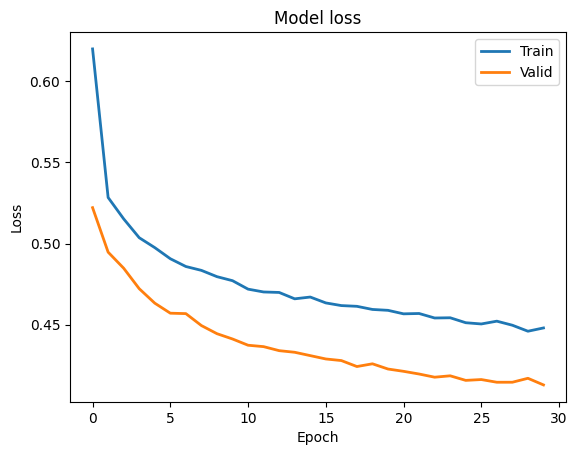

In [28]:
plt.plot(model_history['loss'], linewidth=2, label='Train')
plt.plot(model_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

132/132 [==============================] - 1s 4ms/step


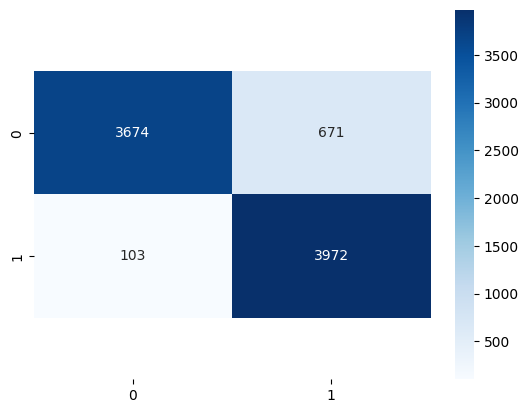

2369/2369 [==============================] - 8s 3ms/step
[[0.08359818]
 [0.9780448 ]
 [0.81724244]
 ...
 [0.9606856 ]
 [0.8051662 ]
 [0.91344434]]


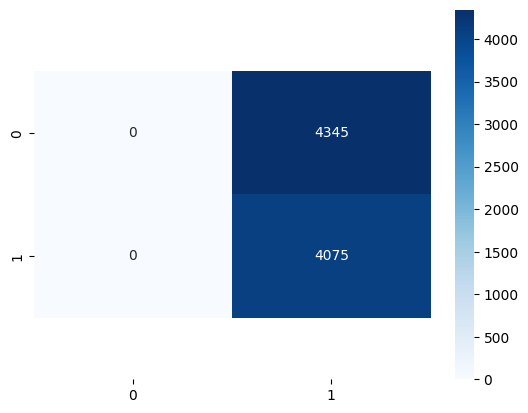

1/1 [==============================] - 0s 70ms/step
[[1]]


In [70]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.1
classification_threshold = 0.25

def evaluate(y_pred):
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = low_risk_real_value
    y_pred_numeric[y_pred==False] = high_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_cv_scaled = y_scaler.inverse_transform(y_test_numeric)
    y_cv_mse = y_cv_scaled[np.where(y_cv_scaled >= -6.0)]
    y_pred_mse = y_pred_numeric[np.where(y_cv_scaled >= -6.0)]
    
    mse = mean_squared_error(y_cv_mse, y_pred_mse)
    
        
    hm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
y_model = model.predict(X_test, batch_size=batch)
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate(y_model)
pred = model.predict(X_train)
print(pred)


#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate(y_constant)

#Predicting last value
y_last = X_test[-1]
y_last = y_last.reshape(1, y_last.shape[0], y_last.shape[1])
predictions = model.predict(y_last)
threshold = classification_threshold  # You can adjust this threshold as needed
y_last_pred = (predictions > threshold).astype(int)

# Print the predicted boolean value
print(y_last_pred)
# y_last = (y_last > threshold_scaled).reshape(-1,1)
# print(y_last)
# evaluate(y_last)
# print(y_last)


(75777, 1)
[[ True]
 [False]
 [ True]
 ...
 [ True]
 [ True]
 [False]]


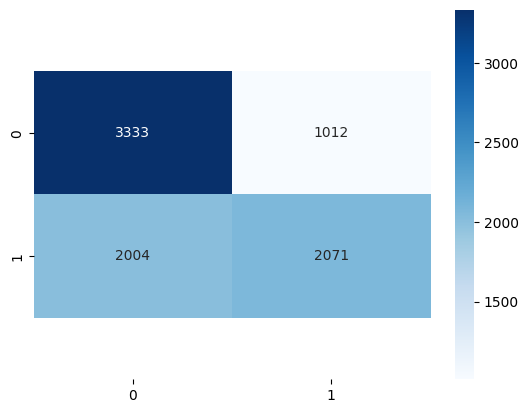

[[ True]
 [False]
 [ True]
 ...
 [ True]
 [ True]
 [False]]


In [71]:
print(pred.shape)
#Predicting last value
y_last = X_test[:,-1,1]
y_last = (y_last > threshold_scaled).reshape(-1,1)
print(y_last)
evaluate(y_last)
print(y_last)


In [29]:
from joblib import dump

dump(model, 'risk_model.joblib')

['risk_model.joblib']

In [43]:
df1 = pd.read_csv("test_data.csv")
df1 = df1.drop("c_rcs_estimate", axis=1)
df1 = df1.dropna(how='any')
df1 = df1.groupby('event_id').filter(conditions)
df1["mission_id"] = df1["mission_id"].astype('category')
df1["c_object_type"] = df1["c_object_type"].astype('category')
df1 = pd.get_dummies(df1)
df1["event_length"] = df1.groupby('event_id')['event_id'].transform('count')
df1 = pd.DataFrame(X_scaler.transform(df1), columns=df1.columns)
data1 = []
df1 = df1[features]
df1.groupby("event_id").apply(df_to_3darray)
data1 = np.array(data1)
X1, y1 = data1[:,:timestep_X,:], data1[:,timestep_X:,target_feture]
X1 = X1[:,:,1:23]
y1_boolean = (y1 > threshold_scaled).reshape(-1,1)




ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- mission_id_13
- mission_id_14


In [37]:
X_test1 = np.array(X).reshape(1,5,22)
model1 = load('risk_model.joblib')
pred = model1.predict(X1[-1])
print(pred)


ValueError: cannot reshape array of size 9261670 into shape (1,5,22)

In [35]:
print(X_train[-1].shape)
print(len(used_features))

(5, 22)
22


In [ ]:
pd.read_csv("train_data.csv")